In [2]:
!pip install keras-tuner
!pip install mat73
#from google.colab import drive
#drive.mount('/content/drive')
import tensorflow as tf
from tensorflow import keras
import numpy as np
import scipy.io as sio
from tensorflow.keras.utils import to_categorical
import mat73
from keras.callbacks import ReduceLROnPlateau
import sklearn.metrics
from sklearn.utils import shuffle 
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Conv3D, MaxPooling3D, BatchNormalization
import matplotlib.pyplot as plt

In [3]:
mat_file = sio.loadmat('ExtractedFeatures_1s/data.mat')
mat_file_labels = sio.loadmat('ExtractedFeatures_1s/label.mat')
count = 0
accuracy = []

data = mat_file['data']
labels = mat_file_labels['label']

labels = labels[0]
labels_edited = np.empty(675)
for i in range(0,45):
  labels_edited[i*15:(i+1)*15] = labels

data, labels_edited = shuffle(data, labels_edited)

max = np.max(data)
min = np.min(data)

#Normalizing data
data = data/max
data = (data - np.mean(data))/np.std(data)

#Splitting Dataset into train, validation, test 
train_labels = labels_edited[0:550]
test_labels = labels_edited[550:600]
train_data = data[0:550]
test_data = data[550:600]
final_test = data[600:675]
final_labels = labels_edited[600:675]
cf_labels = np.where(final_labels== -1, 2, final_labels) #Label in the form for confusion matrix
un, co = np.unique(cf_labels, return_counts=True)
print(f'Unique: {un}, Counts: {co}')

train_labels_reshaped = train_labels.reshape(-1,1) #Formatting for input to the CNN model
test_labels_reshaped = test_labels.reshape(-1,1)
final_labels_reshaped = final_labels.reshape(-1,1)

train_labels_reshaped = to_categorical(train_labels_reshaped, 3) #One Hot Encoding
test_labels_reshaped = to_categorical(test_labels_reshaped, 3)
final_labels_reshaped = to_categorical(final_labels_reshaped, 3)

rnn_train = train_data.reshape(550, 62, -1) #Formatting for CNN input
rnn_test = test_data.reshape(50, 62, -1)
rnn_train = np.transpose(rnn_train, (0,2,1))
rnn_test = np.transpose(rnn_test, (0,2,1))

final_rnn_test = final_test.reshape(75, 62, -1)
final_rnn_test = np.transpose(final_rnn_test, (0,2,1))

Unique: [0. 1. 2.], Counts: [26 28 21]


In [6]:
#K Fold Cross Validation Test

seed = 7
from sklearn.model_selection import StratifiedKFold
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []; cvscores_rnn = []; cvscores_hybrid = []; cvscores_ensemble = []
for train, test in kfold.split(data, labels_edited):
  # CNN Model
  model = Sequential([
    Conv2D(filters= 64, kernel_size= 5, input_shape = (62,265,5), padding= 'same'), #kernel_regularizer=tf.keras.regularizers.l1(0.01), activity_regularizer=tf.keras.regularizers.l2(0.01)),
    Conv2D(filters= 64, kernel_size= 3, padding= 'same'),
    Conv2D(filters= 64, kernel_size= 3, padding= 'same'),
    MaxPooling2D(pool_size= 2,strides = 2),
    #BatchNormalization(),
    Dropout(rate= 0.3),
    Conv2D(filters= 128, kernel_size= 3, padding= 'same'), #kernel_regularizer=tf.keras.regularizers.l1(0.01), activity_regularizer=tf.keras.regularizers.l2(0.01)),
    Conv2D(filters= 128, kernel_size= 3, padding= 'same'),
    MaxPooling2D(pool_size= 2, strides = 2),
    #BatchNormalization(),
    Dropout(rate= 0.2),

    Conv2D(filters= 256, kernel_size= 3, padding= 'same'), #kernel_regularizer=tf.keras.regularizers.l1(0.01), activity_regularizer=tf.keras.regularizers.l2(0.01)),
    MaxPooling2D(pool_size= 2, strides = 2),
    #BatchNormalization(),
    Dropout(rate= 0.25),

    Conv2D(filters= 512, kernel_size= 3, padding= 'same'),
    MaxPooling2D(pool_size= 2, strides= 2),
    #BatchNormalization(),
    Dropout(rate= 0.3),
    
    Flatten(),

    Dense(512, activation= 'relu'), #kernel_regularizer=tf.keras.regularizers.l1(0.01), activity_regularizer=tf.keras.regularizers.l2(0.01)),
    #BatchNormalization(),
    Dropout(rate= 0.4),
    Dense(256, activation= 'relu'),
    #BatchNormalization(),
    Dropout(rate= 0.2),
    Dense(64, activation= 'relu'),
    #BatchNormalization(),
    Dense(3, activation= 'softmax')
  ])

  #Compile CNN Model
  model.compile(optimizer= keras.optimizers.Adam(learning_rate=9e-5), loss= keras.losses.categorical_crossentropy, metrics= ['accuracy', tf.keras.metrics.RootMeanSquaredError()])  
  
  #Fit the CNN model
  reduce_lr_cnn = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-7) #patience = 5 and factor = 0.9

  history = model.fit(
    train_data,
    train_labels_reshaped,
    batch_size = 64,
    epochs=100, 
    validation_data=(test_data, test_labels_reshaped),
    callbacks = [reduce_lr_cnn]
  )

  
  #Evaluate and print on every run
  scores = model.evaluate(x= final_test, y = final_labels_reshaped)
  
  #Implementing Ensemble (Stacking method) using a meta model 

  #Generating Predictions
  pred = np.argmax(model.predict(train_data), axis=-1)
  inputs = [pred]
  inputs = np.array(inputs).T

  pred_test = np.argmax(model.predict(test_data), axis=-1)
  inputs_test = [pred_test]
  inputs_test = np.array(inputs_test).T



  #Evaluation, Print and store Results
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)


Epoch 1/100
9/9 [==============================] - 44s 5s/step - loss: 1.1482 - accuracy: 0.3636 - root_mean_squared_error: 0.4817 - val_loss: 0.9974 - val_accuracy: 0.6800 - val_root_mean_squared_error: 0.4467
Epoch 2/100
9/9 [==============================] - 45s 5s/step - loss: 1.0622 - accuracy: 0.4327 - root_mean_squared_error: 0.4609 - val_loss: 0.9763 - val_accuracy: 0.6200 - val_root_mean_squared_error: 0.4409
Epoch 3/100
9/9 [==============================] - 47s 5s/step - loss: 0.9840 - accuracy: 0.4964 - root_mean_squared_error: 0.4440 - val_loss: 0.8705 - val_accuracy: 0.5000 - val_root_mean_squared_error: 0.4147
Epoch 4/100
9/9 [==============================] - 48s 5s/step - loss: 0.8562 - accuracy: 0.5873 - root_mean_squared_error: 0.4098 - val_loss: 0.6793 - val_accuracy: 0.7600 - val_root_mean_squared_error: 0.3557
Epoch 5/100
9/9 [==============================] - 48s 5s/step - loss: 0.7575 - accuracy: 0.6636 - root_mean_squared_error: 0.3872 - val_loss: 0.5799 - val_

Accuracy Average: 88.13333332538605, Standard Deviation: 1.927578645854329, Max: 90.66666960716248, Min: 83.99999737739563


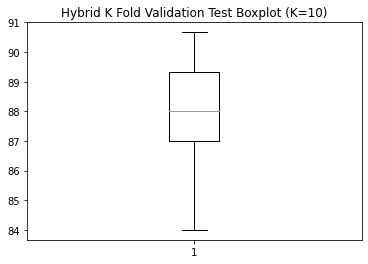

In [7]:
#Print results and Box and Whisker Plot for Hybrid model. Can be changed for each model.

fig, ax = plt.subplots()
ax.set_title('Hybrid K Fold Validation Test Boxplot (K=10)')
ax.boxplot((cvscores), showfliers=True)
print(f'Accuracy Average: {np.mean(cvscores)}, Standard Deviation: {np.std(cvscores)}, Max: {np.max(cvscores)}, Min: {np.min(cvscores)}')

#Uncomment to save results and box and whisker plots
#np.savetxt('hybrid_accuracies.csv', cvscores_hybrid, delimiter=',')
#plt.savefig('Hybrid_boxplot.jpg')